Visit my blog for further content. [jmtirado.net](https://jmtirado.net)

# Introduction

The [Free Music Archive](https://freemusicarchive.org) (FMA) offers free access to open licensed music. This makes the FMA the perfect dataset for music analysis. It provides not only metadata about the track, artist, album, etc. but also the music file itself. The project was originally described in this [paper](https://arxiv.org/abs/1612.01840) presented at the ISMIR in 2017. Additionally, the authors have a GitHub repo with plenty of details and Jupyter notebooks explaining how to process the data ([here](https://github.com/mdeff/fma)).

We are going to use PySpark from a data analyst perspective to explore this dataset. In the aforementioned GitHub repo, you can find how to process this dataset using Pandas. Remember, that Spark now supports the Pandas API.

This notebook shows how to manipulate a real dataset using PySpark to answer the following question:

> Does a song with a long title have a longer duration?

## Disclaimer

This notebook does not pretend to be a scientific work. This is only an example of how to use PySpark for data analysis and therefore it has to be considered as a tutorial.

## The dataset

The FMA dataset contains metadata and features in a single zipped file [fma_metadata.zip](https://os.unil.cloud.switch.ch/fma/fma_metadata.zip) (342 MiB). A brief description of the dataset:

- tracks.csv: per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks.
- genres.csv: all 163 genres with name and parent (used to infer the genre hierarchy and top-level genres).
- features.csv: common features extracted with librosa.
- echonest.csv: audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks.

Run the code below to download and uncompress this dataset to a temporal folder. It may take a while.


In [1]:
import tempfile

fma_url = 'https://os.unil.cloud.switch.ch/fma/fma_metadata.zip'
temp_dir = tempfile.gettempdir()
target_file = temp_dir+'/fma_metadata.zip'
fma_path = temp_dir+'/fma_metadata'

In [2]:
from urllib.request import urlretrieve
import os
import zipfile
import glob

print(f'Download fma_metadata to {target_file}...')
path, headers = urlretrieve(fma_url, target_file)
print('Done')

print('Unzip...')
with zipfile.ZipFile(target_file, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)
print('Done')

for f in glob.glob1(fma_path, '*'):
    print(f)

Download fma_metadata to /tmp/fma_metadata.zip...
Done
Unzip...
Done
genres.csv
raw_albums.csv
checksums
not_found.pickle
README.txt
raw_artists.csv
raw_genres.csv
raw_tracks.csv
raw_echonest.csv
tracks.csv
echonest.csv
features.csv


In [3]:
tracks_path = fma_path + '/raw_tracks.csv'
artists_path = fma_path + '/raw_artists.csv'
genres_path = fma_path + '/raw_genres.csv'


Now we can read the files.

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName('fma').master('local').getOrCreate()

24/02/13 20:18:52 WARN Utils: Your hostname, cthulhu resolves to a loopback address: 127.0.1.1; using 192.168.1.161 instead (on interface wlan0)
24/02/13 20:18:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/13 20:18:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


For our purposes, with the `raw_tracks` file is enough. 

In [6]:
tracks = spark.read.format('csv').option('header','true').load(tracks_path)


# Brief data analysis and cleaning

Like in any dataset, we should take a first look at the content and prepare it for our purposes. This will probably require some cleaning.

Let's take a look at the amount of tracks we have in this dataset.


In [7]:
total_tracks = tracks.count()

print(f'There is a total of {total_tracks} tracks')

There is a total of 117393 tracks


Interestingly, this does not match the number given in the paper (106574 tracks). Let's remove repeated entries, if any.

In [8]:
tracks = tracks.distinct()
print(f'After removing duplicated entries, we have {tracks.count()} tracks')

24/02/13 20:19:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


After removing duplicated entries, we have 115092 tracks


We have already removed some entries, but we can do better. We are not interested in any track without genres. 

This could be a bit tricky. The `genres` column contains a json object. If no genres are set, the array is empty. Luckily, the `json_array_length` function checks the length of a json array for us. We can filter by the array length.

In [9]:
from pyspark.sql.functions import json_array_length
tracks = tracks.filter(json_array_length(tracks.track_genres)>0)
tracks.count()

106747

OK. We removed a good number of entries.

What about tracks with no duration? Let's filter them. Interestingly, the `track_duration` is a string with format `HH:mm:ss`. This is not the best format for us. At this moment, we will compare with `'00:00'` and remove.

In [10]:
tracks = tracks.filter(tracks.track_duration != '00:00')
tracks.count()

106729

After removing tracks with not duration we have 106729 entries. We said that we want to understand the relationship between track duration and the song's title. This means that we will have to discard songs with unknown title. We can do this with the `isnotnull` function from the `pyspark.sql.functions` package.

In [11]:
from pyspark.sql.functions import isnotnull
tracks = tracks.filter(isnotnull(tracks.track_title))
print(f"After removing tracks with unknown title we have {tracks.count()} tracks")

After removing tracks with unknown title we have 105771 tracks


Finally, we can get rid of the columns we are not going to use during our analysis.

In [12]:
tracks = tracks.select(tracks.track_id, tracks.track_duration, tracks.track_title, tracks.track_genres)
tracks.show(5, False)

+--------+--------------+----------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_id|track_duration|track_title                                   |track_genres                                                                                                                                                                                                        |
+--------+--------------+----------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|177     |02:09         |Petty Hate Machine                            |[{'genre_id': '25', 'genre_title': 'Punk', 'genre_url': 'http://freemu

# Track duration and title length

We are trying to understand if the track's title has an impact in the track duration. Obviously, for this we need the duration and the title length. We have already done some cleaning and preparation for this. Unfortunately, the `track_duration` is represented with format `HH:mm:ss` where it would be more useful having something like seconds. For the title length it is enough to count the number of characters. Let's see how we can compute both features.


## Compute track duration

We currently have the track duration expressed in a time duration format: '00:10' for durations shorter than one hour or '01:12:45'. This format is not specially handy. It would be more useful for us expressing this value in seconds. We are going to compute the equivalent in seconds. For this operation, we define a `udf` function to process the `track_duration` for every row. Basically, we split the string into its elements (hours, minutes, and seconds) and compute the number of seconds.  

In [13]:
from pyspark.sql.functions import udf

# We build a custom UDF to transform the track_duration column to seconds
# Something like 02:48 will become 168 seconds
@udf
def to_seconds(input):
    if input is None:
        return 0
    tokens = input.split(':')
    num_tokens = len(tokens)
    if len(tokens) > 3:
        print(f"Wrong input thing: {input}")
        return 0
    seconds = 0
    for i in range(num_tokens-1,-1,-1):
        t = tokens[i]
        if not t.isdigit():
            print(f"Wrong input thing: {input}")
            return 0
        if i < num_tokens - 1:    
            seconds += int(t) * (60 ** (num_tokens - i - 1))
        else:
            seconds += int(t)
    
    return seconds




In [14]:
# Transform the track_duration to seconds
tracks = tracks.withColumn('track_duration_secs', to_seconds('track_duration'),)
tracks.select('track_duration', 'track_duration_secs').show(5, False)

+--------------+-------------------+
|track_duration|track_duration_secs|
+--------------+-------------------+
|02:09         |129                |
|00:59         |59                 |
|03:54         |234                |
|00:36         |36                 |
|01:29         |89                 |
+--------------+-------------------+
only showing top 5 rows



There is something important to be considered here. The type of the returned column is not an `int`.

In [15]:
tracks.schema['track_duration_secs'].dataType

StringType()

We have maintained the type of the initial `track_duration` column. We were looking for an integer, so we can cast the column type.

In [16]:
tracks = tracks.withColumn('track_duration_secs', tracks.track_duration_secs.cast('int'))
tracks.schema['track_duration_secs'].dataType                  

IntegerType()

In [17]:
tracks.select('track_duration', 'track_duration_secs').show(5, False)

+--------------+-------------------+
|track_duration|track_duration_secs|
+--------------+-------------------+
|02:09         |129                |
|00:59         |59                 |
|03:54         |234                |
|00:36         |36                 |
|01:29         |89                 |
+--------------+-------------------+
only showing top 5 rows



## Compute the title length

For the title length, we can use one of the functions available in the `pyspark.sql.functions` package. The `length` function will return the length of any string. We add the `track_title_length` column with the corresponding value.

In [18]:
from pyspark.sql.functions import length

tracks = tracks.withColumn('track_title_length', length(tracks.track_title))
tracks.select('track_title', 'track_title_length').show(5, False)

+----------------------------------------------+------------------+
|track_title                                   |track_title_length|
+----------------------------------------------+------------------+
|Petty Hate Machine                            |18                |
|Appear To Be                                  |12                |
|Climbing To The Top                           |19                |
|40 Seconds After Albany - A Bridge Called Hate|46                |
|Jaws Drop Baby Side                           |19                |
+----------------------------------------------+------------------+
only showing top 5 rows



That was easy.

# Analysis of track duration and title length

Some exploratory anaysis of the track duration and title length to know what we have here.

## Track duration

For a better understanding of the track duration, let's take a look at the data distribution with a histogram. For this purpose, we are going to use the `histogram_numeric` function. This could be done using other available functionalities included in `pyplot` or `pandas`. However, for large datasets we would not take advantage of the spark computational performance. 

The `histogram_numeric` function returns the bins and the occurrences for each bin.

In [19]:
from pyspark.sql.functions import histogram_numeric, lit

hist = tracks.select(histogram_numeric(tracks.track_duration_secs, lit(20))).take(1)
hist

[Row(histogram_numeric(track_duration_secs, 20)=[Row(x=81, y=95.0), Row(x=184, y=81990.0), Row(x=387, y=15996.0), Row(x=601, y=3663.0), Row(x=807, y=1328.0), Row(x=1005, y=711.0), Row(x=1228, y=586.0), Row(x=1465, y=421.0), Row(x=1755, y=339.0), Row(x=1998, y=148.0), Row(x=2227, y=114.0), Row(x=2466, y=79.0), Row(x=2686, y=50.0), Row(x=2864, y=35.0), Row(x=3078, y=39.0), Row(x=3345, y=32.0), Row(x=3661, y=132.0), Row(x=7346, y=2.0), Row(x=11023, y=2.0), Row(x=18333, y=9.0)])]

Now we will extract the bins with their corresponding counts and use the `hist` function from pyplot.

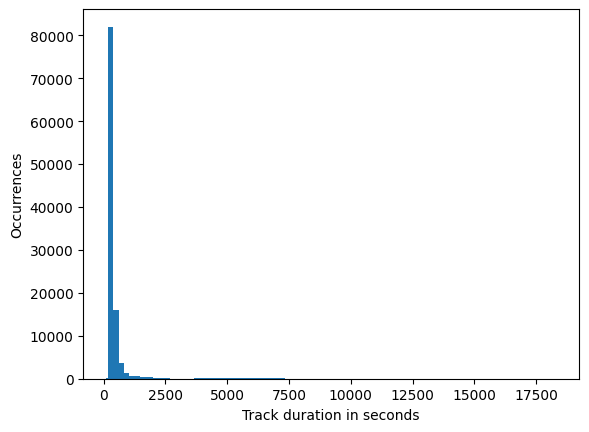

In [20]:
import matplotlib.pyplot as plt

bins = [i.x for i in hist[0][0]]
counts = [i.y for i in hist[0][0]]

plt.hist(bins, bins, weights=counts)
plt.xlabel("Track duration in seconds")
_=plt.ylabel("Occurrences")


Well, we have a long-tailed data distribution. What are the quantiles?

In [21]:
quantiles_track_duration = tracks.approxQuantile('track_duration_secs', [.10,.50,.90, .99], 0)
print(f"Track duration Quantiles for 10: {quantiles_track_duration[0]}, 50: {quantiles_track_duration[1]}, 90: {quantiles_track_duration[2]}, and  99: {quantiles_track_duration[3]}")

Track duration Quantiles for 10: 91.0, 50: 217.0, 90: 455.0, and  99: 1553.0


99% of our observations are smaller than 1553 seconds. We discard everything greater than that.

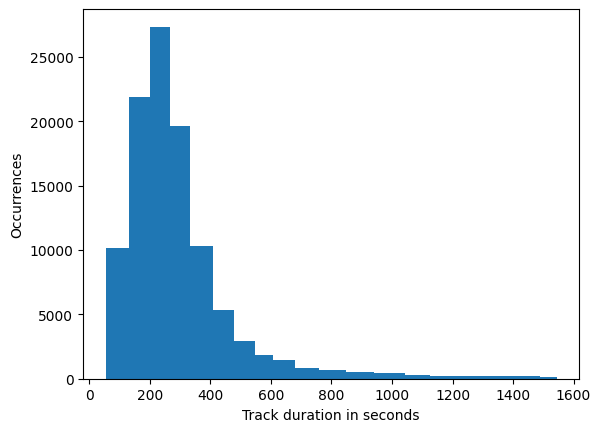

In [22]:
hist = tracks.where(tracks.track_duration_secs <= quantiles_track_duration[3])\
            .select(histogram_numeric('track_duration_secs', lit(20))).take(1)

bins = [i.x for i in hist[0][0]]
counts = [i.y for i in hist[0][0]]

plt.hist(bins, bins, weights=counts)
plt.xlabel("Track duration in seconds")
_ = plt.ylabel("Occurrences")

This looks better now. However, we cannot forget that we have a number of outliers, and we may need to have a deeper understanding of what is going on here. This is an exercise we are not going to do by now.

## Title length

We are going to run the same analysis we did in the previous section for the track duration. We are going to repeat this operation so we better put it into a function.

In [23]:
def compute_hist(df, col_name, num_bins=20):
    hist = df.select(histogram_numeric(col_name, lit(num_bins))).take(1)

    bins = [i.x for i in hist[0][0]]
    counts = [i.y for i in hist[0][0]]
    return (bins, counts)

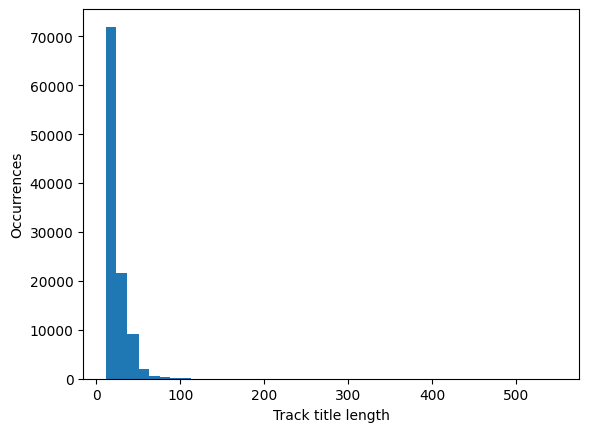

In [24]:
bins, counts = compute_hist(tracks, 'track_title_length')
plt.hist(bins, bins, weights=counts)
plt.xlabel("Track title length")
_ = plt.ylabel("Occurrences")

We have another long-tailed distribution. Let's check quantiles.

In [25]:
quantiles_title_length = tracks.approxQuantile('track_title_length', [.10,.50,.90, .99], 0)
print(f"Track title length Quantiles for 10: {quantiles_title_length[0]}, 50: {quantiles_title_length[1]}, 90: {quantiles_title_length[2]}, and  99: {quantiles_title_length[3]}")

Track title length Quantiles for 10: 6.0, 50: 14.0, 90: 32.0, and  99: 60.0


99% of the titles have less than 60 characteres. We can ignore anything larger than that.

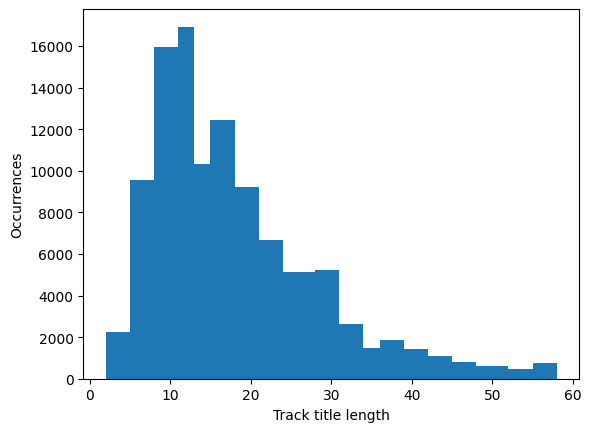

In [26]:
bins, counts = compute_hist(tracks.where(tracks.track_title_length <= quantiles_title_length[3]), 'track_title_length')

plt.hist(bins, bins, weights=counts)
plt.xlabel("Track title length")
_ = plt.ylabel("Occurrences")

# Is the song title relevant for the track duration?

In the previous section we conducted a basic exploratory analysis for `track_duration_secs` and `track_title_length`. Now the idea is to see if there is a correlation between both variables. Again, our hypothesis is that a song with a long title could increase songs' duration.

Initially, we plot the duration vs the title length.

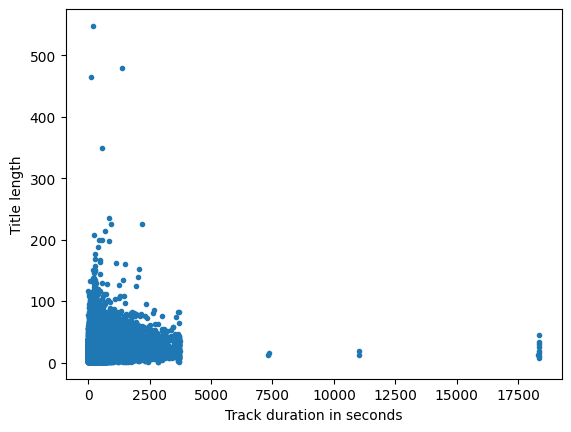

In [27]:
plt.xlabel("Track duration in seconds")
plt.ylabel("Title length")
_ = plt.plot(tracks.select('track_duration_secs').collect(), tracks.select('track_title_length').collect(), '.')

Initially, I would not say that we have any linear dependency between both variables. Let's remove the observations beyond the 99 quantile to have a better view.

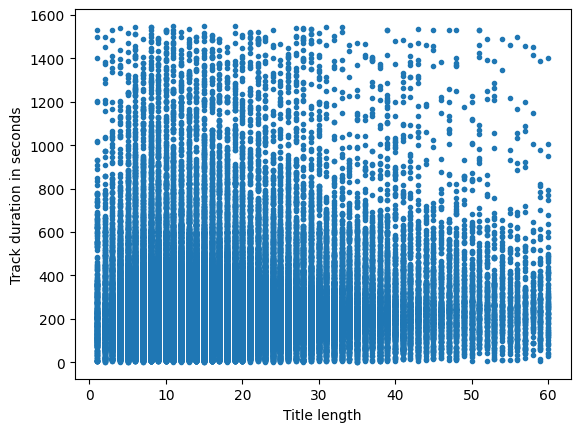

In [28]:
plt.xlabel("Title length")
plt.ylabel("Track duration in seconds")

subset = tracks.select('track_duration_secs', 'track_title_length').where((tracks.track_duration_secs < quantiles_track_duration[3]) & 
                                                                          (tracks.track_title_length <= quantiles_title_length[3]))

_ = plt.plot(subset.select('track_title_length').collect(), subset.select('track_duration_secs').collect(), '.')

Again, nothing clear from a visual point of view. The moment of truth. What about the correlation value?

In [29]:
corr = tracks.corr('track_title_length', 'track_duration_secs')
corr_99 = subset.corr('track_title_length', 'track_duration_secs')

print(f"The correlation between duration and title length is {corr}")
print(f"The correlation below the 99 percentile is {corr_99}")

The correlation between duration and title length is 0.08265139112077975
The correlation below the 99 percentile is 0.06314520555385048


Correlation is particularly low. We cannot claim that there is a correlation between both variables. Our hypothesis could not be confirmed. The good thing, we know how to discard this hypothesis using PySpark and some statistics :)


# Genres

We have shown that there is not a clear relation between the title length and the track duration. However, our previous analysis was a bit naive and ignored the fact that music genres can be difficult to compare. What if we repeat our analysis segregating by music genres?

First, we need to extract the genre from the `track_genres` column. This column contains a json object with the list of genres a song can belong to. A son can belong to different genres. For the sake of simplicity, we are going to extract only the id and name of the first music genre and add it to a column. For this, we use the `get_json_object` function that interprets json paths and returns the corresponding value.

In [30]:
from pyspark.sql.functions import get_json_object

tracks = tracks.withColumn('genre_title', get_json_object('track_genres', '$[0].genre_title'))
tracks = tracks.withColumn('genre_id', get_json_object('track_genres', '$[0].genre_id'))
tracks.select('track_title', 'genre_title', 'genre_id').show(5, False)

+----------------------------------------------+-----------+--------+
|track_title                                   |genre_title|genre_id|
+----------------------------------------------+-----------+--------+
|Petty Hate Machine                            |Punk       |25      |
|Appear To Be                                  |Lo-Fi      |27      |
|Climbing To The Top                           |Folk       |17      |
|40 Seconds After Albany - A Bridge Called Hate|Electronic |15      |
|Jaws Drop Baby Side                           |Rock       |12      |
+----------------------------------------------+-----------+--------+
only showing top 5 rows



Let's make a first attempt to see the correlation for a particular genre. Let's say "Rock".

0.14907336659230266

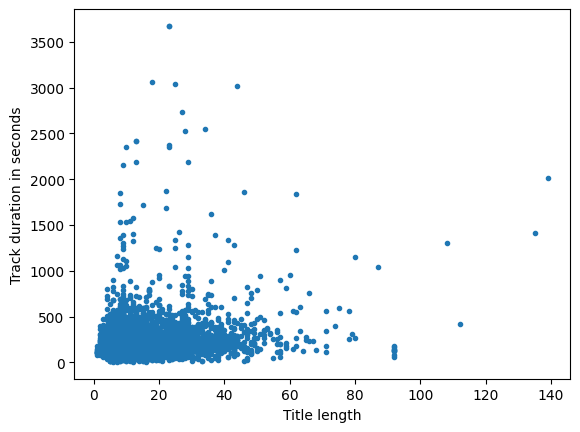

In [31]:
rock = tracks.select('track_duration_secs', 'track_title_length').where(tracks.genre_title=='Rock')

plt.xlabel("Title length")
plt.ylabel("Track duration in seconds")
_=plt.plot(rock.select('track_title_length').collect(), rock.select('track_duration_secs').collect(), '.')
rock.corr('track_duration_secs', 'track_title_length')

This is interesting. With this correlation value we cannot claim that title length and track duration are related, but this value is better than the one we found for the entire dataset.

We can compute the correlation between `track_duration_secs` and `track_title_length` for every genre and see what we have.

In [34]:
from pyspark.sql.functions import corr, count
corr_by_genre = tracks.groupby('genre_title').agg(corr('track_duration_secs', 'track_title_length').alias('corr'),
                                                 count('genre_title').alias('occur')).sort('corr', ascending=False)
corr_by_genre.show()

+--------------------+-------------------+-----+
|         genre_title|               corr|occur|
+--------------------+-------------------+-----+
|          Space-Rock|  0.678568121316952|    7|
|               Tango| 0.6329100564262486|    7|
|           Chill-out| 0.6033554398842059|   61|
|               Radio| 0.6014651648355663|   27|
|              Skweee| 0.5934473444699694|    5|
|              Thrash| 0.5831407529547351|    6|
|         Black-Metal| 0.5827209790337382|   45|
|           Brazilian|   0.55335408763509|   17|
|               Polka|  0.527741890814964|   33|
|        Spoken Weird|   0.50783901267039|  125|
|           Jazz: Out| 0.5057760861825155|   70|
|             No Wave| 0.4710368929166127|  135|
|       Asia-Far East| 0.4026402194110572|   46|
|              Indian|0.38254761413518046|   13|
|      Composed Music|0.37494838797172636|   77|
|              Banter|0.36901299214158506|    9|
|          Rockabilly| 0.3614560030633164|   17|
|         Drum & Bas

Interestingly, if we compute the correlation for every genre separately we get higher correlation values. Said that, the values are not specially high and the number of observations is not high neither. For example, "Space-Rock" has 0.67 correlation with 7 occurrences. Meanwhile "Chill-out" is 0.60 with 61 observations. If we sort the results by the number of occurrences per genre.



In [35]:
corr_by_genre.sort('occur', ascending=False).show()

+------------------+--------------------+-----+
|       genre_title|                corr|occur|
+------------------+--------------------+-----+
|        Electronic| 0.09422485149167782|20540|
|       Avant-Garde| 0.11075413682221796| 9073|
|      Experimental| 0.09004022527246255| 6716|
|              Rock| 0.14907336659230266| 6622|
|               Pop| 0.10700131090439918| 6158|
|              Folk|  0.0855429284045298| 4244|
|           Hip-Hop|  0.1322582147786929| 4083|
|              Punk|  0.1391367336446937| 3462|
|             Noise| 0.05587489409976939| 3343|
|        Soundtrack|  0.1463408907615455| 3057|
|             Lo-Fi| 0.10475194414906629| 2907|
|  Experimental Pop| 0.08095682384459792| 1996|
|              Jazz| 0.12437740801815118| 1895|
|         Classical| 0.17043937455621433| 1765|
|Ambient Electronic|-0.01489813168950...| 1669|
|     International| 0.04523395912526749| 1653|
|             Blues|-0.02420189404801...| 1646|
|        Indie-Rock|0.003130712416778...

# Conclusion

We have explored the FMA dataset to answer the question "does the title length increases the duration of a song?". For this purpose, we have used PySpark and pyplot. Our humble analysis has determined that we cannot claim that the title length impacts the duration of a track. For the aggregated dataset we find low correlation between the track duration and the title length. Furthermore, we perform a correlation analysis segregating the dataset per music genres. We find relevant correlation values (0.6) for certain genres. However, the number of occurrences for these genres is not enough to claim any additional finding. 

I hope you found this notebook useful.

Visit my blog for further content. [jmtirado.net](https://jmtirado.net)